# Weld Quality Prediction - Exploratory Data Analysis (EDA)
## Overview
This notebook is the first in a series of notebooks that does the exploratory data analysis and the data preprocessing of this dataset destined to predict the weld quality. 
The preprocessing is divided in three steps :
1. **Oultier handling**: Use domain expertise and IQR strategies to find the outliers in the dataset, and replace them with NaN.
2. **Missing values handling**: Use different imputing strategies to fill in the missing values for the useful columns.
3. **Standardising and normalising the data**: Apply classic standardisation and normalisation techniques, notably useful for further EDA steps like PCA.
4. **Encoding the categorical values**: Three categorical values were detected: AC_DC, ElectrodePolarity and WeldType.

Each notebook correspond to a step and is intentionally self contained for readability and modularity purposes. 

At the end of each data preprocessing notebook, a csv file is generated containing the preprocessing modifications. The next step's notebook starts with the last generated csv.

The goal is to predict the yield strength of the weld.


# Data preprocessing: Handling outliers
The strategy is to first, validate the voltage and current values for each type of welding. These values are well known in domain expertise, and can vary heavily from a weld type to the other, so it makes sense to filter them first based on weld type.

Then, we apply an IQR to all the columns, based on the weld type. We made the hypothesis (backed up by domain expertise) that each weld type can have vastly different characteristics and chemical compositions.

We also made the hypothesis that the Weld Type column has no errors and can be used reliably.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from IPython.display import display

## 1. Data Loading

In [2]:
columns = [
    "C", "Si", "Mn", "S", "P", "Ni", "Cr", "Mo", "V", "Cu", "Co", "W",
    "O", "Ti", "N", "Al", "B", "Nb", "Sn", "As", "Sb",
    "Current", "Voltage", "AC_DC", "ElectrodePolarity", "HeatInput",
    "InterpassTemp", "WeldType", "PWHT_Temp", "PWHT_Time",
    "YieldStrength", "UTS", "Elongation", "ReductionArea",
    "CharpyTemp", "CharpyImpact", "Hardness", "FATT50", "PrimaryFerrite",
    "Ferrite2ndPhase", "AcicularFerrite", "Martensite", "FerriteCarbide",
    "WeldID"
]

In [3]:
# Load the dataset
df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')
print(f"Dataset loaded with shape: {df.shape}")
df.head()

Dataset loaded with shape: (1652, 44)


C:\Users\marie\AppData\Local\Temp\ipykernel_42536\2997884695.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')


,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,CharpyTemp,CharpyImpact,Hardness,FATT50,PrimaryFerrite,Ferrite2ndPhase,AcicularFerrite,Martensite,FerriteCarbide,WeldID
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch


## 2. Dataset Analysis

#### Missing Data Assessment

In [4]:
# Calculate missing data percentages
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage.sort_values(ascending=False).round(2)
print("Missing data percentages per column (sorted descending):")
pd.DataFrame({'Missing %': missing_percentage})

Missing data percentages per column (sorted descending):


,Missing %
FATT50,98.12
W,95.46
Martensite,94.61
FerriteCarbide,94.61
Ferrite2ndPhase,94.55
AcicularFerrite,94.55
PrimaryFerrite,94.07
Co,92.19
Hardness,91.65
As,85.84


Some weld types namings are inconsistent in the database. Mainly:
1. ShMA and MMA mean the same thing, shielded manual metal arc.
2. SMA, SAA and SA mean the same thing, submerged metal arc.

We handle this inconsistency by only keeping MMA and SA.

In [5]:
# Normalize WeldType categorical values
def normalize_weld_types(df):
    """
    Normalize inconsistent WeldType values.
    - 'ShMA' -> 'MMA' (Shielded Metal Arc)
    - 'SMA' -> 'SA' (Submerged Arc)
    - 'SAA' -> 'SA' (alternate notation for Submerged Arc)
    """
    if 'WeldType' not in df.columns:
        print("Warning: 'WeldType' column not found.")
        return df

    # Strip whitespace for consistent comparison
    weld_series = df['WeldType'].astype(str).str.strip()

    # Identify values to replace
    mask_shma = df['WeldType'].notna() & weld_series.eq('ShMA')
    mask_sma = df['WeldType'].notna() & weld_series.eq('SMA')
    mask_saa = df['WeldType'].notna() & weld_series.eq('SAA')

    replacements = []
    if mask_shma.any():
        count = int(mask_shma.sum())
        replacements.append(f"'ShMA' -> 'MMA' ({count} occurrences)")
        df.loc[mask_shma, 'WeldType'] = 'MMA'

    if mask_sma.any():
        count = int(mask_sma.sum())
        replacements.append(f"'SMA' -> 'SA' ({count} occurrences)")
        df.loc[mask_sma, 'WeldType'] = 'SA'

    if mask_saa.any():
        count = int(mask_saa.sum())
        replacements.append(f"'SAA' -> 'SA' ({count} occurrences)")
        df.loc[mask_saa, 'WeldType'] = 'SA'

    if replacements:
        print("Applied WeldType normalizations:")
        for rep in replacements:
            print(f"  - {rep}")
    else:
        print("No WeldType normalizations needed.")

    return df

# Apply normalization
df = normalize_weld_types(df)

# Display WeldType distribution
print("\nWeldType value counts (excluding NaN):")
weld_counts = df['WeldType'].dropna().astype(str).str.strip().value_counts()
display(weld_counts)

nan_count = df['WeldType'].isna().sum()
print(f"NaN count in WeldType: {nan_count}")

print("\nUnique WeldType values (sorted):")
unique_welds = sorted(df['WeldType'].dropna().astype(str).str.strip().unique())
display(unique_welds)

Applied WeldType normalizations:
  - 'ShMA' -> 'MMA' (40 occurrences)
  - 'SAA' -> 'SA' (4 occurrences)

WeldType value counts (excluding NaN):


WeldType
MMA      1180
SA        265
FCA        87
TSA        87
NGSAW      18
NGGMA       7
GMAA        4
GTAA        4
Name: count, dtype: int64

NaN count in WeldType: 0

Unique WeldType values (sorted):


['FCA', 'GMAA', 'GTAA', 'MMA', 'NGGMA', 'NGSAW', 'SA', 'TSA']

## 3. Data Preprocessing
### Outlier Handling Strategy
**Multi-layered approach for robust data cleaning:**
1. **Domain-specific validation**: Check Current/Voltage against welding standards per WeldType.
2. **Statistical outlier detection**: Apply IQR method within WeldType groups to handle process-specific distributions.
3. **Preservation of data integrity**: Replace outliers with NaN for downstream imputation rather than deletion.

This ensures outliers are identified based on both physical constraints and statistical patterns.

#### Step 1: Domain-Specific Range Validation
Validate Current and Voltage against welding process specifications.

In [6]:
# Load welding process rules
rules_path = '../preprocessing/rules.json'
with open(rules_path, 'r') as f:
    rules = json.load(f)
print(f"Loaded welding rules for {len(rules)} process types.")

# Validate Current and Voltage per WeldType
replaced_count = 0
for idx, row in df.iterrows():
    wtype = str(row['WeldType']).strip() if pd.notna(row['WeldType']) else None
    if wtype in rules:
        rule = rules[wtype]
        # Validate Current
        if 'Current' in rule and pd.notna(row['Current']):
            min_val, max_val = rule['Current']['min'], rule['Current']['max']
            if not (min_val <= row['Current'] <= max_val):
                df.at[idx, 'Current'] = np.nan
                replaced_count += 1
        # Validate Voltage
        if 'Voltage' in rule and pd.notna(row['Voltage']):
            min_val, max_val = rule['Voltage']['min'], rule['Voltage']['max']
            if not (min_val <= row['Voltage'] <= max_val):
                df.at[idx, 'Voltage'] = np.nan
                replaced_count += 1
print(f"Domain validation complete: {replaced_count} values replaced with NaN.")

Loaded welding rules for 8 process types.
Domain validation complete: 95 values replaced with NaN.


In [7]:
def detect_outliers_iqr_grouped(df, group_col='WeldType', exclude_cols=None, min_group_size=4):
    """
    Detect and replace outliers using IQR method within groups.

    Parameters:
    - df: DataFrame to process
    - group_col: Column to group by
    - exclude_cols: Columns to exclude from outlier detection
    - min_group_size: minimum number of non-NaN samples in a group/column required
                      to compute quartiles and apply the IQR rule. Groups/columns
                      with fewer samples will be skipped (not considered statistically
                      meaningful).

    Returns:
    - outlier_report: DataFrame with outlier counts per group/column
    - previews: List of DataFrames showing before/after samples
    """
    if group_col not in df.columns:
        raise ValueError(f"Grouping column '{group_col}' not found in DataFrame.")

    # Select numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_cols:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    outlier_records = []
    previews = []

    # Group by WeldType
    weld_series = df[group_col].astype(str).str.strip()
    for wtype, group in df.groupby(weld_series):
        if wtype.lower() in ('nan', 'none', ''):
            continue

        for col in numeric_cols:
            series = group[col].dropna()
            # Skip groups/columns with too few samples to compute quartiles reliably
            if series.empty or len(series) < int(min_group_size):
                outlier_records.append({'WeldType': wtype, 'column': col, 'outliers_replaced': 0})
                continue

            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1

            if iqr == 0 or pd.isna(iqr):
                outlier_records.append({'WeldType': wtype, 'column': col, 'outliers_replaced': 0})
                continue

            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr

            # Find outliers in the full DataFrame for this group
            mask = (weld_series == wtype) & ((df[col] < lower) | (df[col] > upper))
            count = int(mask.sum())
            outlier_records.append({'WeldType': wtype, 'column': col, 'outliers_replaced': count})

            if count > 0:
                # Sample before/after
                sample_idx = df.loc[mask].index[:5]
                sample_before = df.loc[sample_idx, [col, group_col]].copy().reset_index(drop=True).rename(columns={col: 'before'})
                df.loc[mask, col] = np.nan
                sample_after = df.loc[sample_idx, [col]].copy().reset_index(drop=True).rename(columns={col: 'after'})
                preview = pd.concat([sample_before, sample_after], axis=1)
                preview['column'] = col
                preview['WeldType_group'] = wtype
                previews.append(preview)

    outlier_report = pd.DataFrame(outlier_records).set_index(['WeldType', 'column']).sort_values('outliers_replaced', ascending=False)
    return outlier_report, previews

# Apply outlier detection (use default min_group_size=4; change the argument to adjust behavior)
outlier_report, previews = detect_outliers_iqr_grouped(df, exclude_cols=['WeldID'], min_group_size=10)

print('Outlier replacements by WeldType and column:')
display(outlier_report)

if previews:
    previews_df = pd.concat(previews, ignore_index=True)
    print('\nSample of changed values (first 50):')
    display(previews_df.head(50))
else:
    print('No outliers detected.')

Outlier replacements by WeldType and column:


outliers_replaced
WeldType column                            
MMA      Si                             166
         Voltage                        111
         Cr                              99
         C                               88
         O                               79
...                                     ...
TSA      FATT50                           0
         Ferrite2ndPhase                  0
         AcicularFerrite                  0
         Martensite                       0
         FerriteCarbide                   0

[184 rows x 1 columns]


Sample of changed values (first 50):


,before,WeldType,after,column,WeldType_group
0,1.680,FCA,NaN,Mn,FCA
1,1.740,FCA,NaN,Mn,FCA
2,0.010,FCA,NaN,P,FCA
3,0.011,FCA,NaN,P,FCA
4,0.011,FCA,NaN,P,FCA
5,0.009,FCA,NaN,P,FCA
6,0.011,FCA,NaN,P,FCA
7,0.030,FCA,NaN,Ni,FCA
8,0.030,FCA,NaN,Ni,FCA
9,0.550,FCA,NaN,Ni,FCA


In [8]:
# Dataset summary after preprocessing
print(f"Final dataset shape: {df.shape}")
print(f"Total rows: {len(df)}")
print(f"Total columns: {len(df.columns)}")

Final dataset shape: (1652, 44)
Total rows: 1652
Total columns: 44


## 4. Data Visualization
### Strategy: Distribution Comparison
Visualize pre/post-cleaning distributions for columns with outliers to assess cleaning impact.

Visualizing distributions for 18 columns with outliers...


C:\Users\marie\AppData\Local\Temp\ipykernel_42536\2246456334.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_orig = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')


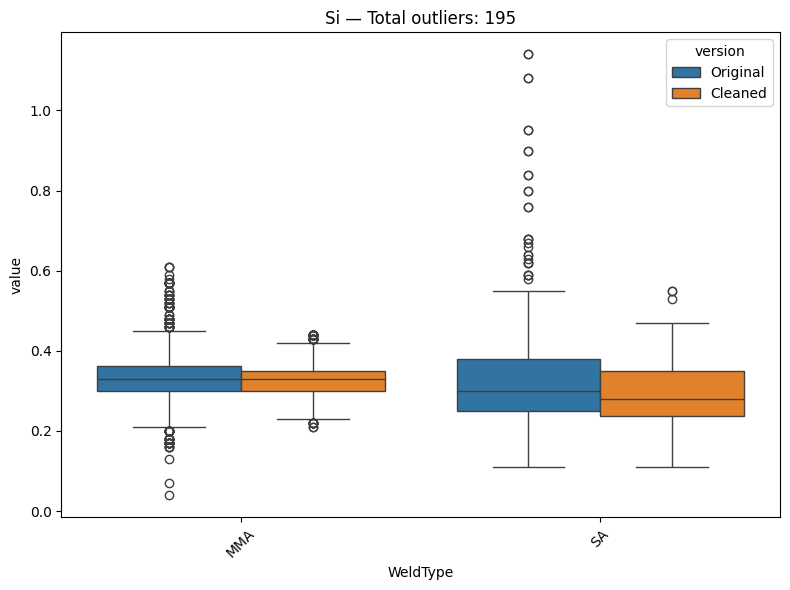

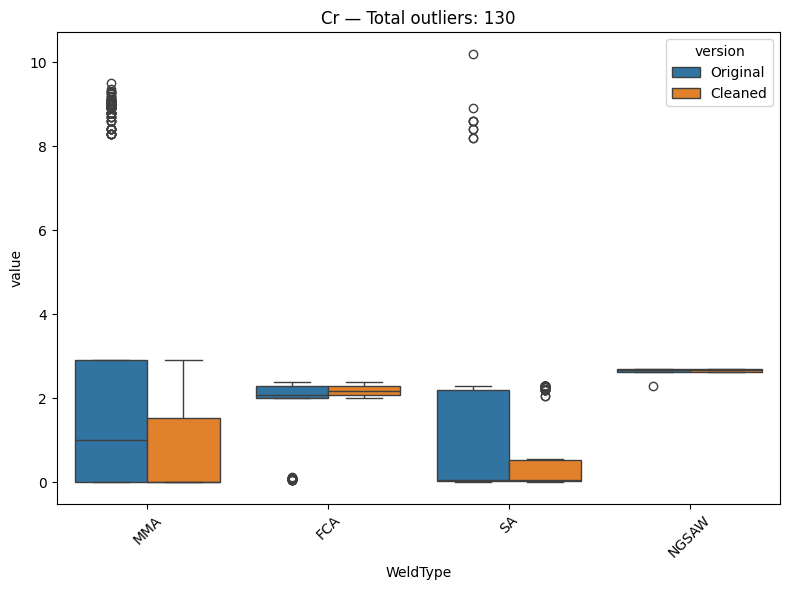

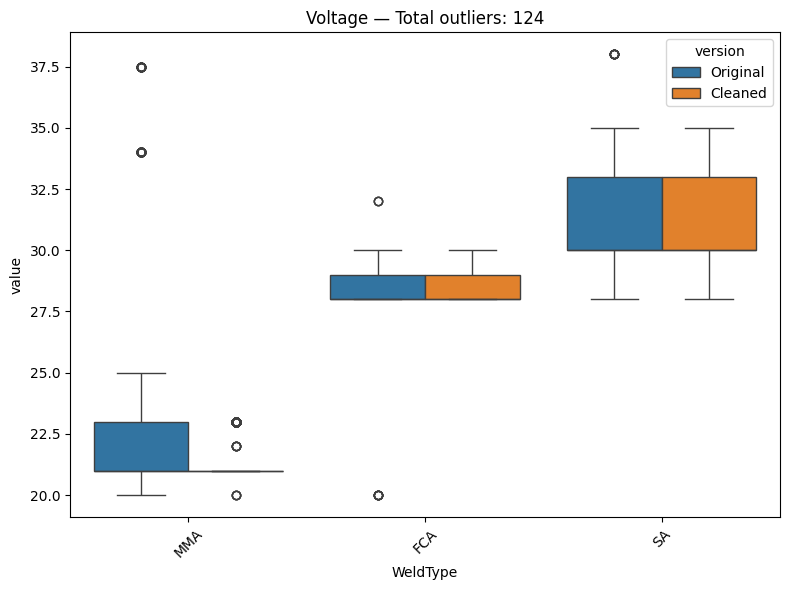

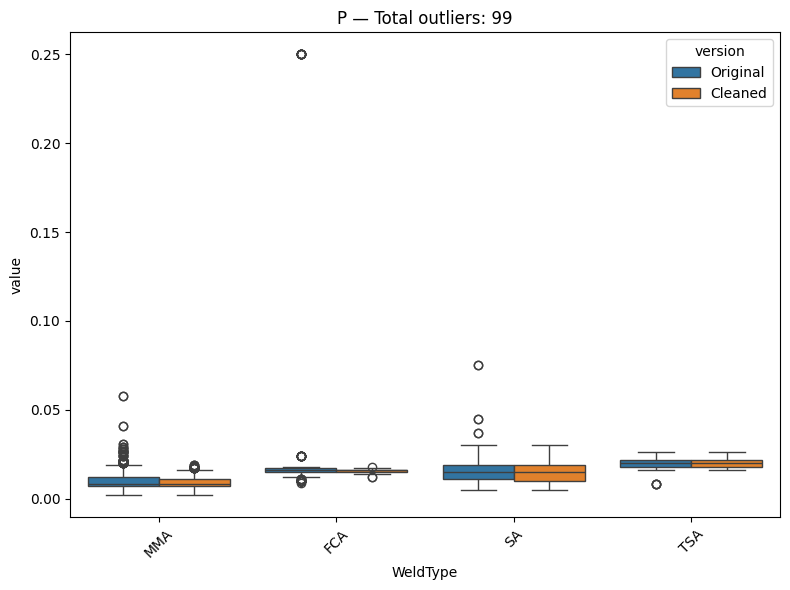

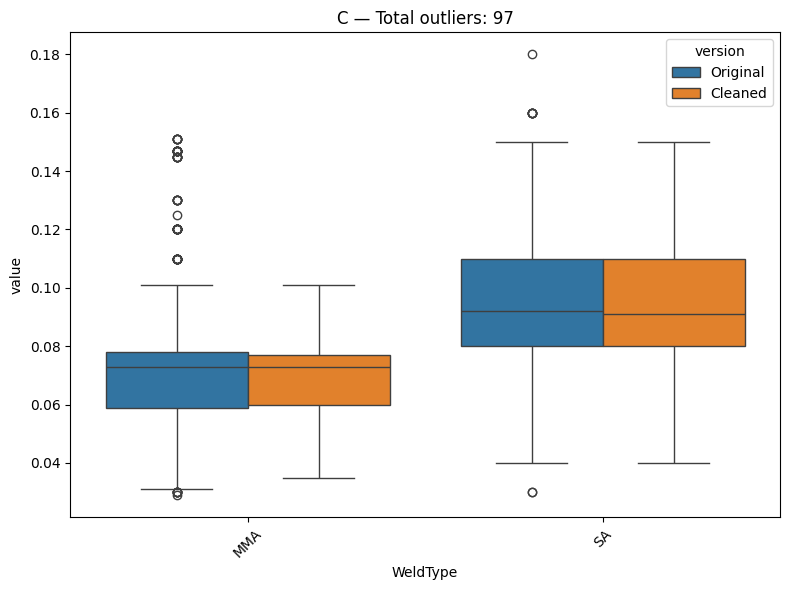

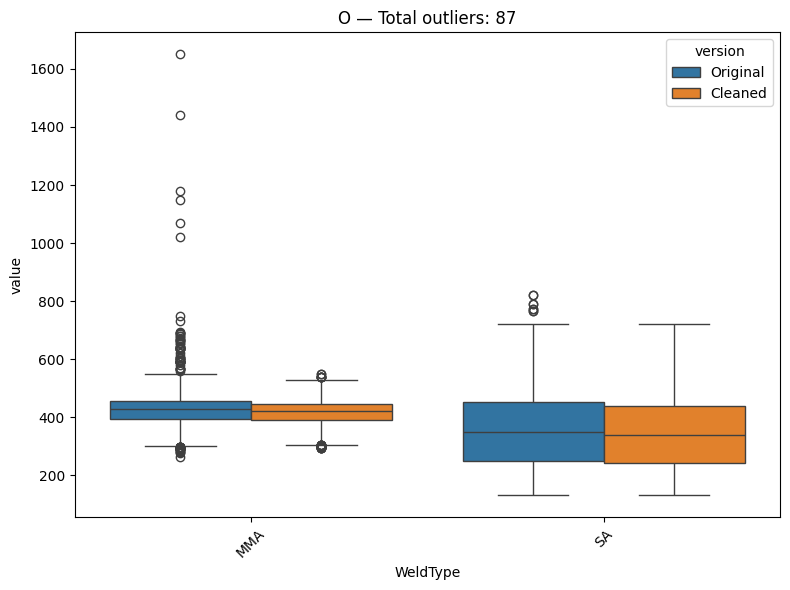

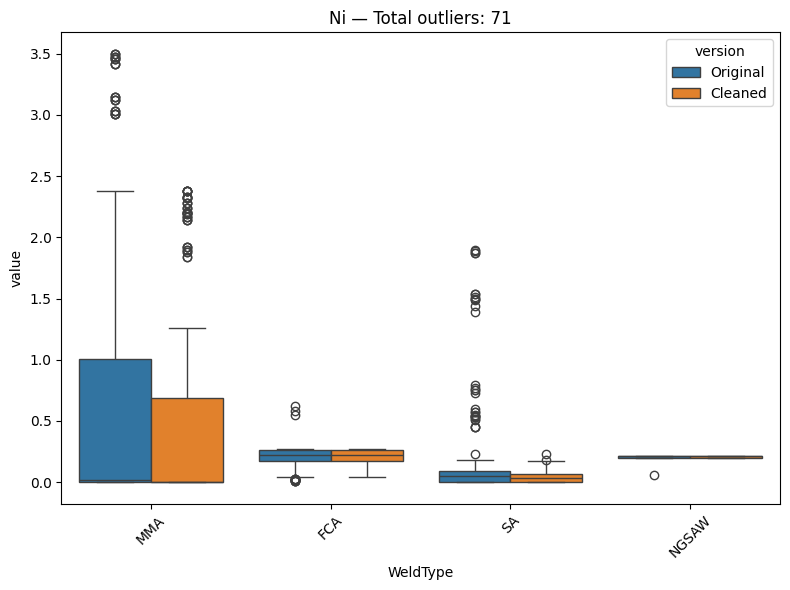

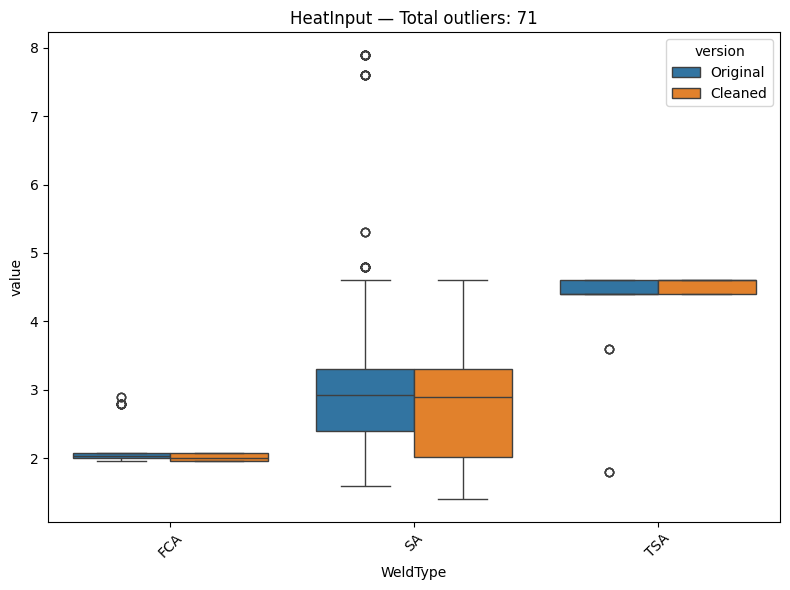

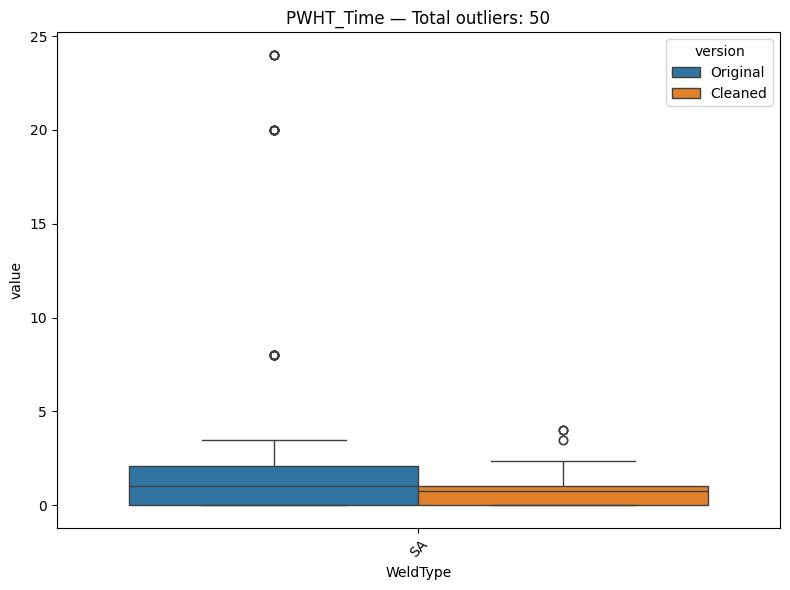

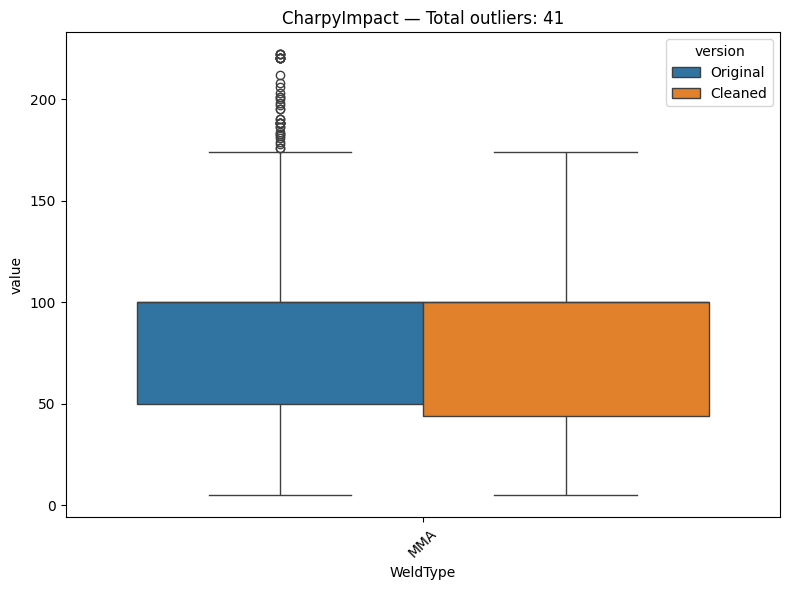

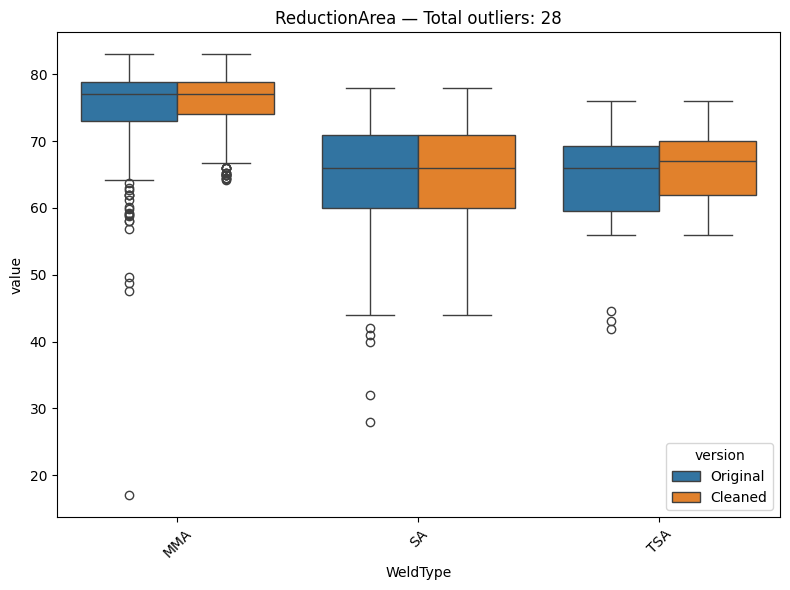

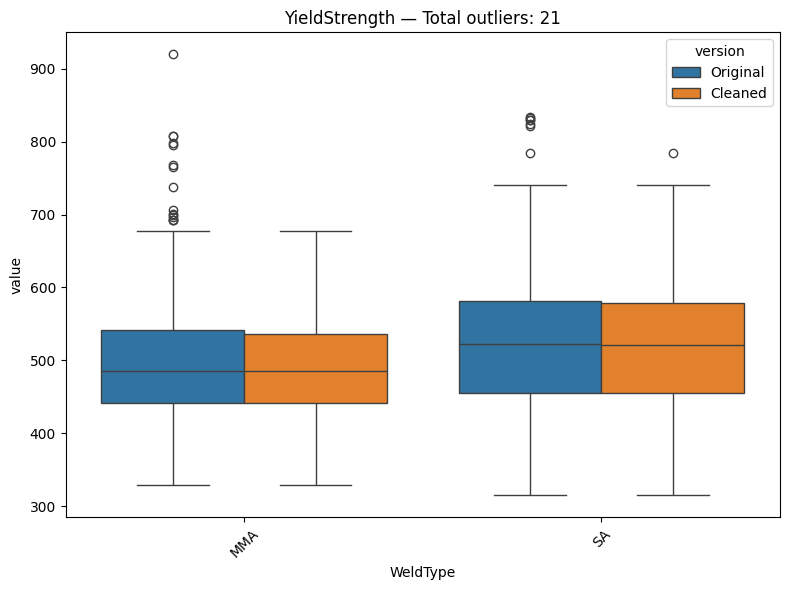

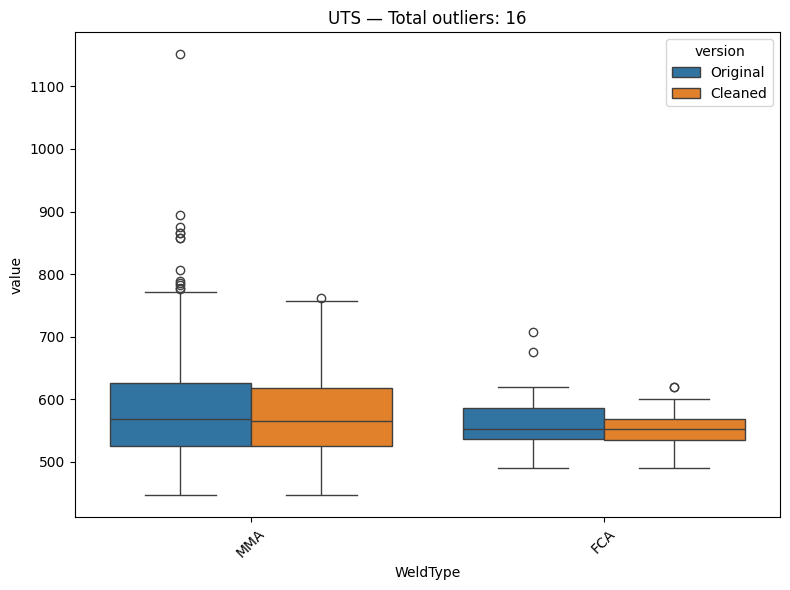

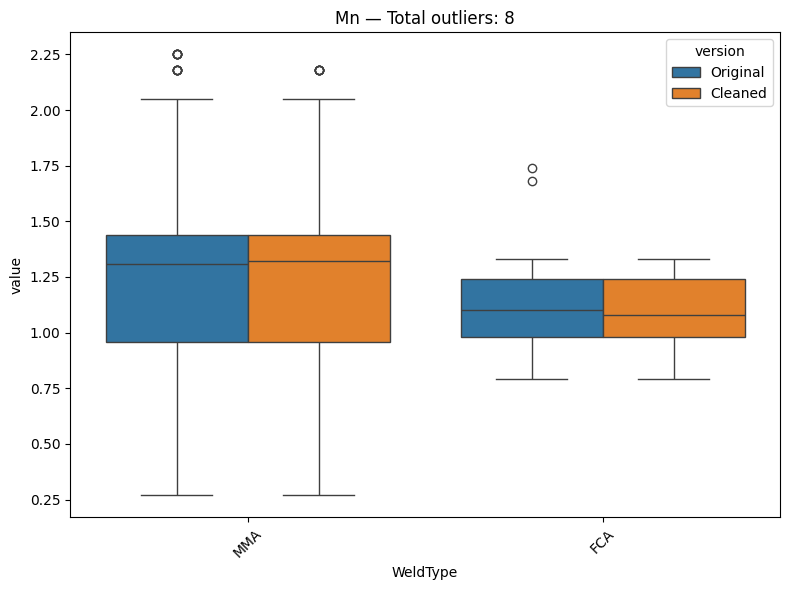

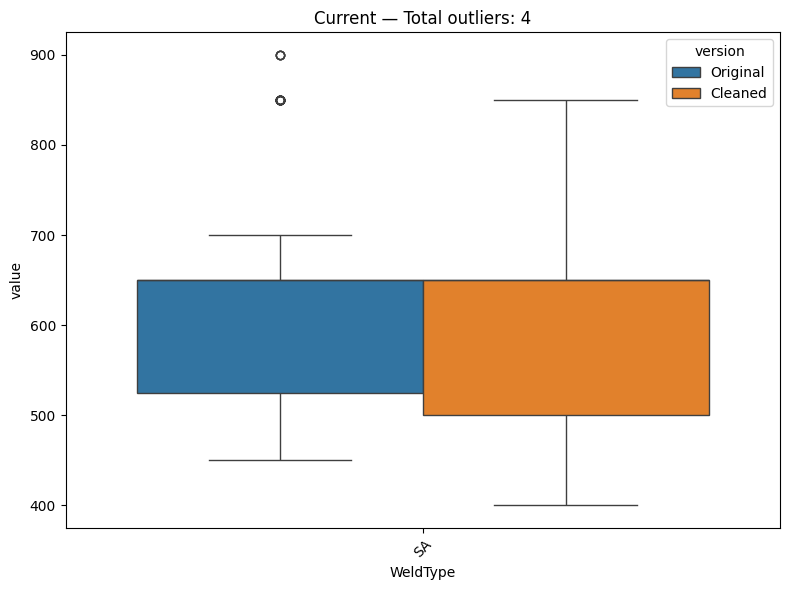

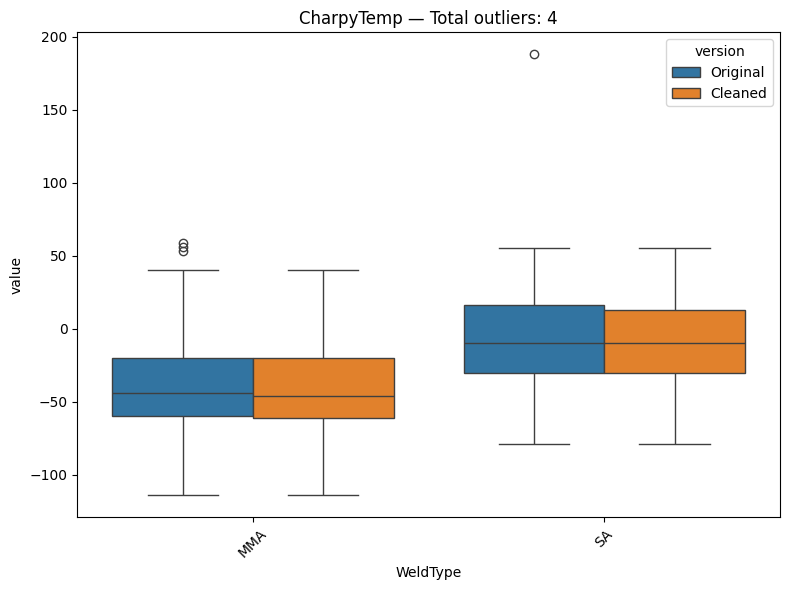

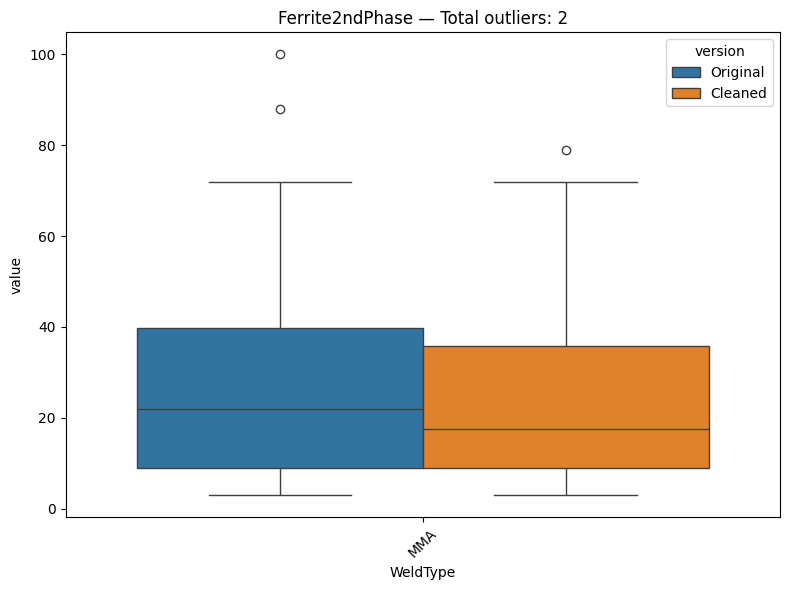

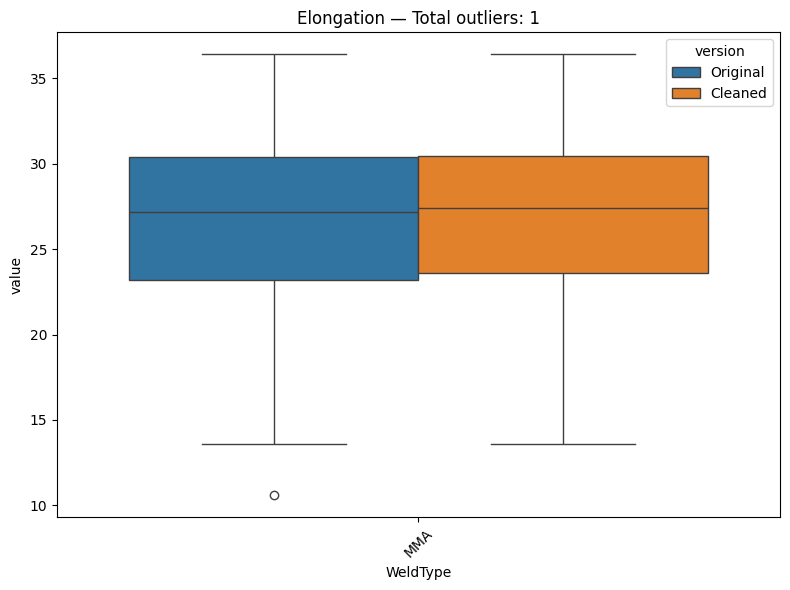

In [9]:
# Reload original data for comparison
df_orig = pd.read_csv("../data/welddb.data", delim_whitespace=True, names=columns, na_values='N')

# Compute outlier report on original data (with bug fix)
def compute_outlier_report(df, group_col='WeldType', exclude_cols=None):
    records = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if exclude_cols:
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    weld_series = df[group_col].astype(str).str.strip()
    for wtype, group in df.groupby(weld_series):
        if wtype.lower() in ('nan', 'none', ''):
            continue
        for col in numeric_cols:
            series = group[col].dropna()
            if series.empty or len(series) < 4:
                records.append({'WeldType': wtype, 'column': col, 'outliers_replaced': 0})
                continue
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1  # Fixed: was incorrect
            if iqr == 0 or pd.isna(iqr):
                records.append({'WeldType': wtype, 'column': col, 'outliers_replaced': 0})
                continue
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            mask = (weld_series == wtype) & ((df[col] < lower) | (df[col] > upper))
            records.append({'WeldType': wtype, 'column': col, 'outliers_replaced': int(mask.sum())})
    return pd.DataFrame(records).set_index(['WeldType', 'column']).sort_values('outliers_replaced', ascending=False)

if 'outlier_report' not in globals() or outlier_report.empty:
    outlier_report = compute_outlier_report(df_orig, exclude_cols=['WeldID'])

# Get columns with outliers
total_by_col = outlier_report.reset_index().groupby('column')['outliers_replaced'].sum().sort_values(ascending=False)
cols_with_outliers = total_by_col[total_by_col > 0].index.tolist()

if not cols_with_outliers:
    print('No columns with outliers to visualize.')
else:
    print(f"Visualizing distributions for {len(cols_with_outliers)} columns with outliers...")
    for col in cols_with_outliers:  # Limit to first 5 for brevity
        per_weld = outlier_report.reset_index().query("column == @col").sort_values('outliers_replaced', ascending=False)
        top_welds = per_weld[per_weld['outliers_replaced'] > 0].head(6)['WeldType'].tolist()

        if not top_welds:
            continue

        # Prepare data for plotting
        df_o = df_orig.loc[df_orig['WeldType'].astype(str).str.strip().isin(top_welds), ['WeldType', col]].copy()
        df_o = df_o.assign(version='Original').rename(columns={col: 'value'})

        df_c = df.loc[df['WeldType'].astype(str).str.strip().isin(top_welds), ['WeldType', col]].copy()
        df_c = df_c.assign(version='Cleaned').rename(columns={col: 'value'})

        plot_df = pd.concat([df_o, df_c], ignore_index=True)
        plot_df['WeldType'] = plot_df['WeldType'].astype(str).str.strip()

        plt.figure(figsize=(max(8, len(top_welds) * 1.2), 6))
        sns.boxplot(x='WeldType', y='value', hue='version', data=plot_df, showfliers=True)
        plt.title(f"{col} — Total outliers: {int(total_by_col.loc[col])}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 5. Data Export
### Strategy: Preserve Cleaned Dataset
Save the processed dataset for modeling while maintaining data integrity.

In [10]:
# Optional: Display full DataFrame (use with caution on large datasets)
# Uncomment the following to view the entire cleaned dataset
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 2000):
#     display(df)

In [11]:
# Export cleaned dataset
output_path = '../data/cleaned_welddb.csv'
df.to_csv(output_path, index=False)
print(f"✅ Cleaned dataset exported to: {output_path}")
print(f"📊 Final shape: {df.shape}")
print("🎯 Ready for the next step!")

✅ Cleaned dataset exported to: ../data/cleaned_welddb.csv
📊 Final shape: (1652, 44)
🎯 Ready for the next step!
